## Helper functions

In [13]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

import numpy as np
import random
import pandas as pd
import graphviz as gv
import matplotlib.pyplot as plt
        
def positive(examples):
    '''
    Calculate the number of positive samples
    '''
    positive_samples = 0
    examples = np.array(examples)
    last_column = examples[:,-1]
    
    for element in last_column:
        if element == 1:
            positive_samples += 1
    return positive_samples

def Binary_entropy(p):
    '''
    Calculate the binary entropy using the equation found in the book.
    '''
    if p in [0,1]:
        return 0
    if 1 - p < 0: 
        return - (p*np.log2(p) + (1 - p) * np.log2(p - 1))
    else:
        return - (p*np.log2(p) + (1 - p) * np.log2(1 - p))

    
def importance_gain(examples, attribute):
    '''
    Calculate the importance using information gain for an attribute i.
    
    '''
    # Initialize 
    N = len(examples)
    remainder = 0
    
    samples_for_one = []
    samples_for_two = []
    Bvalues = []
    
    for e in examples:
        if e[attribute] == 1:
            samples_for_one.append(e)
        elif e[attribute] == 2:
            samples_for_two.append(e)

    # Calculate the B(q) 
    positive_samples1 = positive(samples_for_one)
    Bvalues.append(Binary_entropy(positive_samples1 / len(samples_for_one)))
    
    positive_samples2 = positive(samples_for_two)
    Bvalues.append(Binary_entropy(positive_samples2 / len(samples_for_two)))
    
    posistive_samples_data = positive(examples)
    Bvalues.append(Binary_entropy(posistive_samples_data))
    
    # Calculate the remainder 
    remainder += len(samples_for_one) / N * Bvalues[0]
    remainder += len(samples_for_two) / N * Bvalues[1]

    return Bvalues[-1] - remainder

def importance_random(examples, attribute):
    attribute_importance = []
    for i in attribute:
        attribute_importance.append(random.random())
    attribute_importance = np.array(attribute_importance)
    return attribute[attribute_importance.argmax()]

def IMPORTANCE(examples, attribute, method):
    '''
    Here we calculate the gain using 3 different methods
    1. Information gain. If two or more attributes have the same gain, it will choose the first attribute
    2. Random information gain: If two or more attributes have the same gain, 
    it will choose randomly between the attributes of which gets chosen
    3. Random: Gives each attribute a random importance, and chooses the one that has the highest.
    '''
    gains = []
    if method == 'gain':
        for a in attribute:
            gains.append(importance_gain(examples, a))
        gains1 = np.array(gains)

        max_gain_position = np.array(gains).argmax()
        return attribute[max_gain_position]
    elif method == 'gain_random':
        for a in attribute:
            gains.append(importance_gain(examples, a))
        
        max_gain_position = np.argwhere(gains == np.amax(gains)).flatten().tolist()
        return attribute[random.sample(max_gain_position,1)[0]]
    else:
        return importance_random(examples, attribute)
    
def is_unique(x):
    first_element = x[0]
    for i in x[1:]:
        if i != first_element:
            return False
    return True
    
def PLURALITY(examples):
    '''
    To determine 
    '''
    examples = np.array(examples)
    last_column = examples[:,-1]
    
    plurality = np.bincount(last_column)#.argmax()
    
    if plurality[1] == plurality[2]:
        return random.randint(1,2)
    else:
        return plurality.argmax()


def accuracy(tree, data, printing = False):
    N = len(data)
    correct, wrong = 0, 0
    def check_row(tree, row):
        while tree.children:
            tree = tree.children[row[tree.data]]
        return tree.data
    
    for row in data:
        if check_row(tree, row) == row[-1]:
            correct += 1
        else:
            wrong += 1
    if printing:
        print('The number of correct classifications are: ' 
              + str(correct) + '/' + str(N) + ' or ' + str(round(correct/N*100,2)) +'%')
        print('The number of wrong classifications are: ' 
              + str(wrong) + '/' + str(N) + ' or ' + str(round(wrong/N*100,2)) +'%')
    
    return correct / N
    
def load_data(PATH):
    data = pd.read_csv(PATH)
    data_fixed = data.values.tolist()
    return data_fixed

## Decision tree and main functions

In [24]:
class build_tree:
    def __init__(self, data):
        self.data = data
        self.children = {}
         
def decision_tree_learning(examples, attributes, parents, Values, method):
    '''
    Algorithm found in the book
    
    Y: the value we are trying to predict (which will be the last column in examples)
    
    It supports 3 different methods
    1. Gain (where the first attribute gets chosen if there are more than 1 that shares the same gain)
    2. Information gain with random choosing of attribute if there are multiple values with same gain
    3. Random importance: Each attributes have been assigned a random attribute
    '''
    if len(examples) == 1:
        Y = [examples[0][-1]]
    elif len(examples) == 0:
        Y = []
    else:
        Y = np.array(examples)[:,-1]
    
    if len(examples) == 0:
        return build_tree(PLURALITY(parents))
    elif is_unique(Y):
        return build_tree(Y[0])
    elif not attributes: # check if attributes is empty 
        return build_tree(PLURALITY(Y))
    else:
        A = IMPORTANCE(examples, attributes, method)
        root = build_tree(A)

        attributes = list(attributes)
        attributes.remove(A)
        for value in Values:
            examples_next = []
            for e in examples:
                if e[A] == value:
                    examples_next.append(e)

            subtree = decision_tree_learning(examples_next, attributes, examples, Values, method)
            root.children[vk] = subtree
    return root

def design_tree(training_data, test_data, Values, attributes, method, save_file):
    '''
    This function designs the tree and calculate the accuracies of the training and test set.
    
    It supports 3 different methods
    1. Gain (where the first attribute gets chosen if there are more than 1 that shares the same gain)
    2. Information gain with random choosing of attribute if there are multiple values with same gain
    3. Random importance: Each attributes have been assigned a random attribute
    '''
    def make_tree(DT, tree):
        edges = []
        for edge, value in tree.children.items():
            edges.append(edge)
        if tree.children:
            DT.node(repr(tree), str(tree.data))
            make_tree(DT, tree.children[1])
            make_tree(DT, tree.children[2])
            if tree.children:
                DT.edge(repr(tree), repr(tree.children[1]), label = str(edges[0]))
                DT.edge(repr(tree), repr(tree.children[2]), label = str(edges[1]))
        else:
            DT.node(repr(tree), str(tree.data), color = 'blue')
        return DT
    
    
    if method == 'gain':
        print('Information gain')
        tree = decision_tree_learning(training_data, attributes, None, Values, method = 'gain')
        print('------------------------ TRAIN DATA ------------------------')
        accuracy(tree, training_data, True)
        print('------------------------ TEST  DATA ------------------------')
        accuracy(tree, test_data, True)
        print('')
    elif method == 'gain_random':
        print('Random information gain')
        tree = decision_tree_learning(training_data, attributes, None, Values, method = 'gain_random')
        print('------------------------ TRAIN DATA ------------------------')
        accuracy(tree, training_data, True)
        print('------------------------ TEST  DATA ------------------------')
        accuracy(tree, test_data, True)
        print('')
    elif method == 'random':
        print('Random importance')
        tree = decision_tree_learning(training_data, attributes, None, Values, method = 'random')
        print('------------------------ TRAIN DATA ------------------------')
        accuracy(tree, training_data, True)
        print('------------------------ TEST  DATA ------------------------')
        accuracy(tree, test_data, True)
        print('')
    else:
        print('Please specify a importance method: Either gain, gain_random or random.')
    DT = gv.Digraph(format='svg')
    DT = make_tree(DT, tree)
    DT.render(save_file)

## Main function

Information gain
------------------------ TRAIN DATA ------------------------
The number of correct classifications are: 99/99 or 100.0%
The number of wrong classifications are: 0/99 or 0.0%
------------------------ TEST  DATA ------------------------
The number of correct classifications are: 25/27 or 92.59%
The number of wrong classifications are: 2/27 or 7.41%

Random information gain
------------------------ TRAIN DATA ------------------------
The number of correct classifications are: 99/99 or 100.0%
The number of wrong classifications are: 0/99 or 0.0%
------------------------ TEST  DATA ------------------------
The number of correct classifications are: 22/27 or 81.48%
The number of wrong classifications are: 5/27 or 18.52%

Random importance
------------------------ TRAIN DATA ------------------------
The number of correct classifications are: 99/99 or 100.0%
The number of wrong classifications are: 0/99 or 0.0%
------------------------ TEST  DATA ------------------------
The n

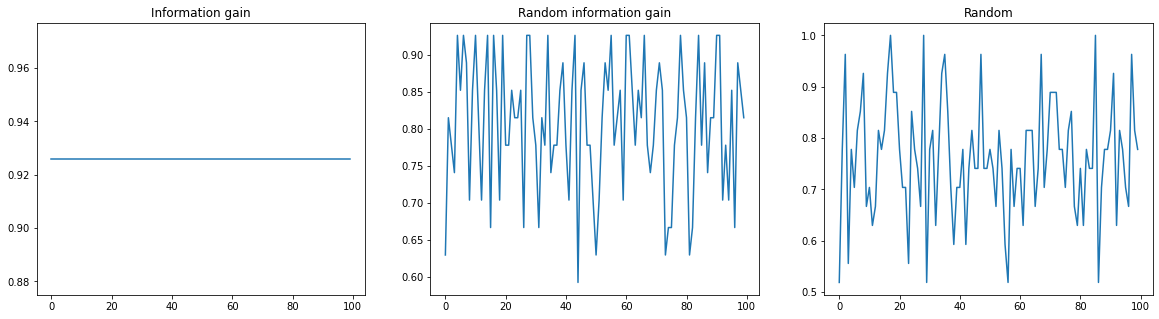

Average test accuracy using random information gain 0.807 +/-0.088
Average test accuracy using random importance 0.761+/-0.112


In [32]:
training_data = load_data('train.csv')
test_data = load_data('test.csv')
Values = [1,2]
attributes = [x for x in range(len(training_data[0])-1)]


importance_types = ['gain', 'gain_random', 'random']
for importance_type in importance_types:
    design_tree(training_data, test_data, Values, attributes, importance_type, importance_type)
    

def simulation(training_data, test_data, Values, attributes):
    # train_accuracy = accuracy(tree, training_data)
    # test_accuracy = accuracy(tree, test_data)
    
    test_accuracy_gain = []
    test_accuracy_random_gain = []
    test_accuracy_random = []
    
    x = []
    
    for i in range(200):
        tree = decision_tree_learning(training_data, attributes, None, Values, method = 'gain')
        test_accuracy_gain.append(accuracy(tree, test_data))
        
        tree = decision_tree_learning(training_data, attributes, None, Values, method = 'gain_random')
        test_accuracy_random_gain.append(accuracy(tree, test_data))
        
        tree = decision_tree_learning(training_data, attributes, None, Values, method = 'random')
        test_accuracy_random.append(accuracy(tree, test_data))
    return test_accuracy_gain, test_accuracy_random_gain, test_accuracy_random

test_g, test_rg, test_r = simulation(training_data, test_data, Values, attributes)

plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.title('Information gain')
plt.plot(test_g)
plt.subplot(1,3,2)
plt.title('Random information gain')
plt.plot(test_rg)
plt.subplot(1,3,3)
plt.title('Random')
plt.plot(test_r)
plt.show()

print('Average test accuracy using random information gain ' + str(np.round(np.mean(test_rg),3)) + ' +/-' + str(np.round(np.std(test_rg),3)))
print('Average test accuracy using random importance ' + str(np.round(np.mean(test_r),3)) + '+/-' + str(np.round(np.std(test_r),3)))

[1 1 1 1 2 2 1 2 2 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 2 1 2]
[1 1 1 1 2 1 2 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1]
0.8518518518518519


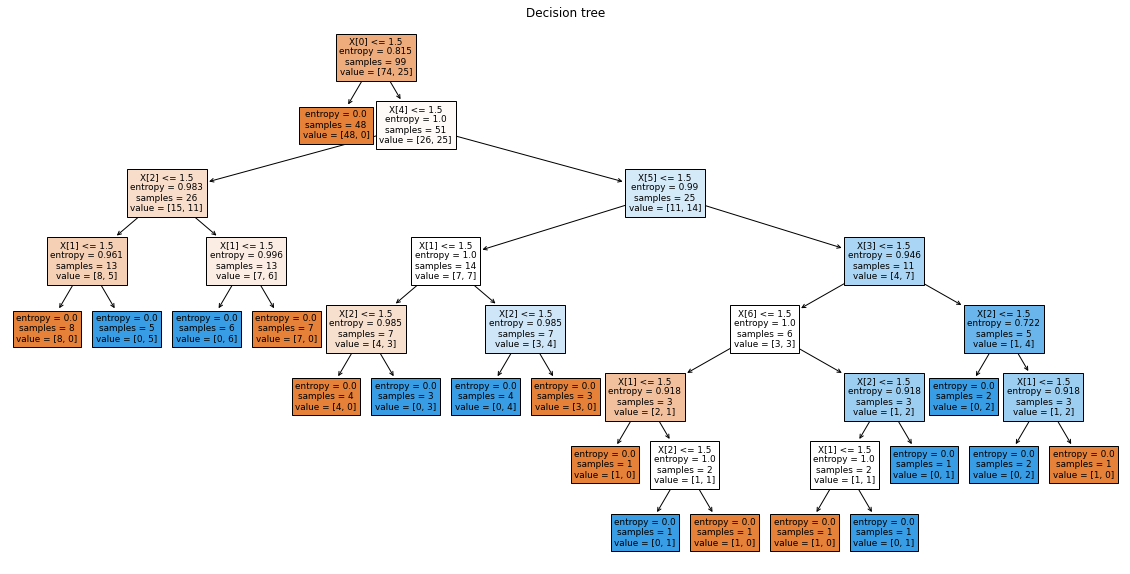

In [31]:
from sklearn import tree
from sklearn.tree import plot_tree

X = np.array(training_data)[:,:-1]
Y = np.array(training_data)[:,-1]
X_test = np.array(test_data)[:,:-1]
Y_test = np.array(test_data)[:,-1]
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(X, Y)

print(clf.predict(X_test))
print(Y_test)

print(sum(clf.predict(X_test) == Y_test) / len(Y_test))


plt.figure(figsize = (20,10))
clf = tree.DecisionTreeClassifier(criterion = 'entropy').fit(X,Y)
plot_tree(clf, filled=True)
plt.title("Decision tree")
plt.show()